In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **DATA PREPARATION**

Handling Missing Values


In [ ]:
input_file = "fra.txt"
output_file = "fra_processed.txt"

with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
    for line in infile:
        columns = line.split("\t")

        if len(columns) >= 2:
            outfile.write(f"{columns[0]}\t{columns[1]}\n")

print(f"File Saved")

File Saved


Vocabulary Construction

In [ ]:
START_TOKEN = 0
END_TOKEN = 1

class Language:
    def __init__(self, language_name):
        self.language_name = language_name
        self.token2index = {}
        self.token2count = {}
        self.index2token = {0: "START", 1: "END"}
        self.total_tokens = 2  # Count START and END

    def addText(self, text):
        for word in text.split(' '):
            self.addToken(word)

    def addToken(self, token):
        if token not in self.token2index:
            self.token2index[token] = self.total_tokens
            self.token2count[token] = 1
            self.index2token[self.total_tokens] = token
            self.total_tokens += 1
        else:
            self.token2count[token] += 1

Text Cleaning and Normalization

In [ ]:
def convertToAscii(input_str):
    return ''.join(
        character for character in unicodedata.normalize('NFD', input_str)
        if unicodedata.category(character) != 'Mn'
    )

# Convert to lowercase, trim, and remove non-alphabetical characters
def cleanString(input_str):
    input_str = convertToAscii(input_str.lower().strip())
    input_str = re.sub(r"([.!?])", r" \1", input_str)
    input_str = re.sub(r"[^a-zA-Z!?]+", r" ", input_str)
    return input_str.strip()

Loading and Preparing Language Data

In [ ]:
def loadLanguages(language1, language2, reverse=False):

    # Read the file and split into lines
    lines = open('fra_processed.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split each line into pairs and normalize
    sentence_pairs = [[cleanString(sentence) for sentence in line.split('\t')] for line in lines]

    # Reverse pairs, create Language instances
    if reverse:
        sentence_pairs = [list(reversed(pair)) for pair in sentence_pairs]
        source_language = Language(language2)
        target_language = Language(language1)
    else:
        source_language = Language(language1)
        target_language = Language(language2)

    return source_language, target_language, sentence_pairs

Filtering Sentence Pairs

In [ ]:
MAX_TOKENS = 10

english_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def validatePair(pair):
    return len(pair[0].split(' ')) < MAX_TOKENS and \
        len(pair[1].split(' ')) < MAX_TOKENS and \
        pair[1].startswith(english_prefixes)


def validatePairs(pair_list):
    return [pair for pair in pair_list if validatePair(pair)]

Processing and Preparing Data

In [ ]:
def processData(source_lang, target_lang, reverse=False):
    source_language, target_language, sentence_pairs = loadLanguages(source_lang, target_lang, reverse)
    sentence_pairs = validatePairs(sentence_pairs)
    for pair in sentence_pairs:
        source_language.addText(pair[0])
        target_language.addText(pair[1])
    return source_language, target_language, sentence_pairs

source_language, target_language, sentence_pairs = processData('eng', 'fra', True)

# **MODELING**

Recurrent Neural Network Encoder for Sequence Embedding

In [ ]:
class RNN_Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_units, dropout_rate=0.1):
        super(RNN_Encoder, self).__init__()
        self.hidden_units = hidden_units

        self.embedding_layer = nn.Embedding(vocab_size, hidden_units)
        self.gru_layer = nn.GRU(hidden_units, hidden_units, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout_rate)

    def forward(self, input_tensor):
        embedded_tensor = self.dropout_layer(self.embedding_layer(input_tensor))
        gru_output, gru_hidden = self.gru_layer(embedded_tensor)
        return gru_output, gru_hidden

RNN Decoder for Sequence Generation with Teacher Forcing

In [ ]:
class RNN_Decoder(nn.Module):
    def __init__(self, hidden_units, output_units):
        super(RNN_Decoder, self).__init__()
        self.embedding_layer = nn.Embedding(output_units, hidden_units)
        self.gru_layer = nn.GRU(hidden_units, hidden_units, batch_first=True)
        self.output_layer = nn.Linear(hidden_units, output_units)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(START_TOKEN)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_TOKENS):
            decoder_output, decoder_hidden = self._forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None  # Return `None` for consistency in the training loop

    def _forward_step(self, input_tensor, hidden):
        output = self.embedding_layer(input_tensor)
        output = F.relu(output)
        output, hidden = self.gru_layer(output, hidden)
        output = self.output_layer(output)
        return output, hidden

Attention Mechanism for Context Vector Calculation

In [ ]:
class AttentionMechanism(nn.Module):
    def __init__(self, units_size):
        super(AttentionMechanism, self).__init__()
        self.linear_W = nn.Linear(units_size, units_size)
        self.linear_U = nn.Linear(units_size, units_size)
        self.linear_V = nn.Linear(units_size, 1)

    def forward(self, query, keys):
        attention_scores = self.linear_V(torch.tanh(self.linear_W(query) + self.linear_U(keys)))
        attention_scores = attention_scores.squeeze(2).unsqueeze(1)

        attention_weights = F.softmax(attention_scores, dim=-1)
        context_vector = torch.bmm(attention_weights, keys)

        return context_vector, attention_weights

Attention-Enhanced RNN Decoder with Teacher Forcing


In [ ]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, units_size, output_units, dropout_rate=0.1):
        super(AttentionDecoderRNN, self).__init__()
        self.embedding_layer = nn.Embedding(output_units, units_size)
        self.attention_mechanism = AttentionMechanism(units_size)
        self.gru_layer = nn.GRU(2 * units_size, units_size, batch_first=True)
        self.output_layer = nn.Linear(units_size, output_units)
        self.dropout_layer = nn.Dropout(dropout_rate)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(START_TOKEN)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attention_weights = []

        for i in range(MAX_TOKENS):
            decoder_output, decoder_hidden, attn_weights = self._forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attention_weights.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attention_weights = torch.cat(attention_weights, dim=1)

        return decoder_outputs, decoder_hidden, attention_weights

    def _forward_step(self, input_tensor, hidden, encoder_outputs):
        embedded_tensor = self.dropout_layer(self.embedding_layer(input_tensor))

        query = hidden.permute(1, 0, 2)
        context_vector, attn_weights = self.attention_mechanism(query, encoder_outputs)
        gru_input = torch.cat((embedded_tensor, context_vector), dim=2)

        output, hidden = self.gru_layer(gru_input, hidden)
        output = self.output_layer(output)

        return output, hidden, attn_weights

Text-to-Tensor Conversion and DataLoader Preparation for Sequence Pairs

In [ ]:
def getTokenIndexes(language, sentence):
    return [language.token2index[token] for token in sentence.split(' ')]

def tensorFromText(language, sentence):
    token_indexes = getTokenIndexes(language, sentence)
    token_indexes.append(END_TOKEN)
    return torch.tensor(token_indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromSentencePair(sentence_pair):
    input_tensor = tensorFromText(source_language, sentence_pair[0])
    target_tensor = tensorFromText(target_language, sentence_pair[1])
    return (input_tensor, target_tensor)

def createDataLoader(batch_size):
    source_language, target_language, sentence_pairs = processData('eng', 'fra', True)

    n = len(sentence_pairs)
    input_ids = np.zeros((n, MAX_TOKENS), dtype=np.int32)
    target_ids = np.zeros((n, MAX_TOKENS), dtype=np.int32)

    for idx, (source, target) in enumerate(sentence_pairs):
        source_ids = getTokenIndexes(source_language, source)
        target_ids_list = getTokenIndexes(target_language, target)
        source_ids.append(END_TOKEN)
        target_ids_list.append(END_TOKEN)
        input_ids[idx, :len(source_ids)] = source_ids
        target_ids[idx, :len(target_ids_list)] = target_ids_list

    dataset = TensorDataset(torch.LongTensor(input_ids).to(device),
                            torch.LongTensor(target_ids).to(device))

    data_sampler = RandomSampler(dataset)
    data_loader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return source_language, target_language, data_loader

# **TRAINING**

Simple Early Stopping Mechanism for Training Optimization

In [ ]:
import numpy as np

class SimpleEarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float('inf')  # Initialize with a large value
        self.epochs_without_improvement = 0
        self.stop_training = False

    def check(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.epochs_without_improvement = 0  # Reset counter
        else:
            self.epochs_without_improvement += 1

        if self.epochs_without_improvement >= self.patience:
            self.stop_training = True

        return self.stop_training

Training Epoch with Early Stopping for Sequence-to-Sequence Models

In [ ]:
def trainForEpochWithSimpleEarlyStopping(data_loader, encoder_model, decoder_model, encoder_optimizer,
          decoder_optimizer, loss_criterion, early_stopping):

    total_epoch_loss = 0
    for batch_data in data_loader:
        input_tensor, target_tensor = batch_data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder_model(input_tensor)
        decoder_outputs, _, _ = decoder_model(encoder_outputs, encoder_hidden, target_tensor)

        loss = loss_criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_epoch_loss += loss.item()

    # Simple validation loss check
    val_loss = total_epoch_loss / len(data_loader)
    if early_stopping.check(val_loss):
        print("Early stopping triggered.")
        return total_epoch_loss / len(data_loader), True

    return total_epoch_loss / len(data_loader), False

Time Estimation for Training Progress

In [ ]:
import time
import math

def convertToMinutes(seconds):
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

def elapsedTime(since, progress):
    current_time = time.time()
    elapsed_seconds = current_time - since
    estimated_seconds = elapsed_seconds / (progress)
    remaining_seconds = estimated_seconds - elapsed_seconds
    return '%s (- %s)' % (convertToMinutes(elapsed_seconds), convertToMinutes(remaining_seconds))

Visualization of Loss and Performance Metrics Over Training Epochs

In [ ]:
import matplotlib.pyplot as plt

def plotLossGraph(loss_points, performance_metrics=None, save_location=None):
    plt.close('all')  # Close any existing figures
    plt.figure(figsize=(12, 6))
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss Curve
    axs[0].plot(loss_points, label='Training Loss')
    axs[0].set_title("Training Loss Over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()


    if save_location:
        plt.savefig(save_location)
        print(f"Plot saved to {save_location}")
    else:
        plt.show()  # Ensure this renders the plot

Model Training with Early Stopping and Translation Evaluation

In [ ]:
def trainModelWithSimpleEarlyStopping(data_loader, encoder_model, decoder_model, epochs, lr=0.001,
               display_every=100, visualize_every=100, patience=3, test_sentences=[]):

    start_time = time.time()
    loss_plot = []
    total_print_loss = 0  # Reset every display_every
    total_plot_loss = 0  # Reset every visualize_every

    encoder_optimizer = optim.Adam(encoder_model.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder_model.parameters(), lr=lr)
    loss_function = nn.NLLLoss()

    # Early stopping setup
    early_stopping = SimpleEarlyStopping(patience=patience)

    for epoch in range(1, epochs + 1):
        epoch_loss, stop_training = trainForEpochWithSimpleEarlyStopping(data_loader, encoder_model, decoder_model, encoder_optimizer, decoder_optimizer, loss_function, early_stopping)
        total_print_loss += epoch_loss
        total_plot_loss += epoch_loss

        if stop_training:
            print(f"Training stopped early at epoch {epoch}.")
            break

        if epoch % display_every == 0:
            avg_print_loss = total_print_loss / display_every
            total_print_loss = 0
            print('%s (%d %d%%) %.4f' % (elapsedTime(start_time, epoch / epochs),
                                        epoch, epoch / epochs * 100, avg_print_loss))

        if epoch % visualize_every == 0:
            avg_plot_loss = total_plot_loss / visualize_every
            loss_plot.append(avg_plot_loss)
            total_plot_loss = 0

    plotLossGraph(loss_plot)

    # After training, generate translations for test sentences
    for sentence in test_sentences:
        decoded_words, decoder_attention = generateTranslation(encoder_model, decoder_model, sentence, source_language, target_language)
        print(f"Original Sentence: {sentence}")
        print(f"Translated Sentence: {' '.join(decoded_words)}")

# **EVALUATION**

Translation Generation from Sequence-to-Sequence Models


In [ ]:
def generateTranslation(encoder_model, decoder_model, sentence, source_language, target_language):
    with torch.no_grad():
        input_tensor = tensorFromText(source_language, sentence)

        encoder_outputs, encoder_hidden = encoder_model(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attention = decoder_model(encoder_outputs, encoder_hidden)

        _, top_index = decoder_outputs.topk(1)
        decoded_indexes = top_index.squeeze()

        decoded_words = []
        for idx in decoded_indexes:
            if idx.item() == END_TOKEN:
                decoded_words.append('<END>')
                break
            decoded_words.append(target_language.index2token[idx.item()])
    return decoded_words, decoder_attention

Random Sentence Translation for Model Evaluation

In [ ]:
def generateRandomTranslations(encoder_model, decoder_model, n=10):
    for i in range(n):
        random_pair = random.choice(sentence_pairs)
        print('>', random_pair[0])
        print('=', random_pair[1])
        output_words, _ = generateTranslation(encoder_model, decoder_model, random_pair[0], source_language, target_language)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

4m 42s (- 70m 32s) (5 6%) 1.0885
9m 13s (- 64m 35s) (10 12%) 0.2969
13m 38s (- 59m 7s) (15 18%) 0.1040
18m 2s (- 54m 7s) (20 25%) 0.0620
22m 29s (- 49m 29s) (25 31%) 0.0510
27m 4s (- 45m 7s) (30 37%) 0.0462
31m 33s (- 40m 34s) (35 43%) 0.0432
35m 56s (- 35m 56s) (40 50%) 0.0410
40m 23s (- 31m 24s) (45 56%) 0.0398
44m 49s (- 26m 53s) (50 62%) 0.0382
49m 15s (- 22m 23s) (55 68%) 0.0372
53m 41s (- 17m 53s) (60 75%) 0.0366
58m 7s (- 13m 24s) (65 81%) 0.0360
62m 41s (- 8m 57s) (70 87%) 0.0355
67m 10s (- 4m 28s) (75 93%) 0.0341
Early stopping triggered.
Training stopped early at epoch 78.


<Figure size 1200x600 with 0 Axes>

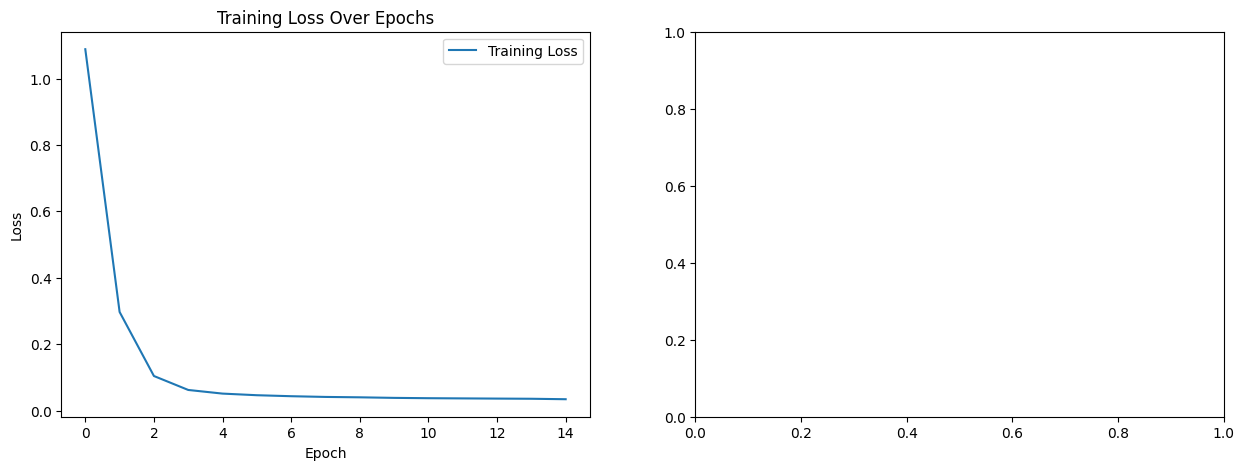

In [ ]:
# Set hyperparameters
hidden_units = 256
batch_size = 64

# Prepare data loader
source_language, target_language, train_data_loader = createDataLoader(batch_size)

# Initialize the encoder and decoder models
encoder_model = RNN_Encoder(source_language.total_tokens, hidden_units).to(device)
decoder_model = AttentionDecoderRNN(hidden_units, target_language.total_tokens).to(device)


# Train the model with simple early stopping and generate translations
trainModelWithSimpleEarlyStopping(
    train_data_loader,
    encoder_model,
    decoder_model,
    epochs=80,
    display_every=5,
    visualize_every=5,
    patience=5,  # Set the patience for early stopping
)
#checked for multiple patience values, 5 worked the best for us, reduced the loss more

In [ ]:
# Save the models
torch.save(encoder_model.state_dict(), "encoder_model.pth")
torch.save(decoder_model.state_dict(), "decoder_model.pth")
print("Models saved.")

Models saved.


In [ ]:
import random

def generateRandomTranslations(encoder_model, decoder_model, source_language, target_language, sentence_pairs, num_samples=5):
    # Pick random sentences from sentence pairs
    random_sentences = random.sample(sentence_pairs, num_samples)

    for pair in random_sentences:
        source_sentence = pair[0]
        target_sentence = pair[1]

        # Generate translation using the encoder and decoder models
        decoded_words, decoder_attention = generateTranslation(encoder_model, decoder_model, source_sentence, source_language, target_language)

        print(f"Original Sentence: {source_sentence}")
        print(f"Translated Sentence: {' '.join(decoded_words)}")
        print(f"Target Sentence: {target_sentence}")
        print("="*50)

# Example usage: Generate translations for 5 random sentences
generateRandomTranslations(encoder_model, decoder_model, source_language, target_language, sentence_pairs, num_samples=5)

Original Sentence: tu es tres intelligent
Translated Sentence: you re very intelligent <END>
Target Sentence: you re very intelligent
Original Sentence: je me melange les pinceaux
Translated Sentence: i m confused <END>
Target Sentence: i m confused
Original Sentence: je ne suis pas different
Translated Sentence: i m no different <END>
Target Sentence: i m no different
Original Sentence: je suis un tantinet jalouse
Translated Sentence: i m a little bit jealous <END>
Target Sentence: i m a little bit jealous
Original Sentence: elles sont sur le point de partir
Translated Sentence: they re about to leave <END>
Target Sentence: they re about to leave


Source Sentence: elles sont jeunes et en bonne sante
Target Sentence: they re young and healthy
Translated Sentence: they re young and healthy <END>


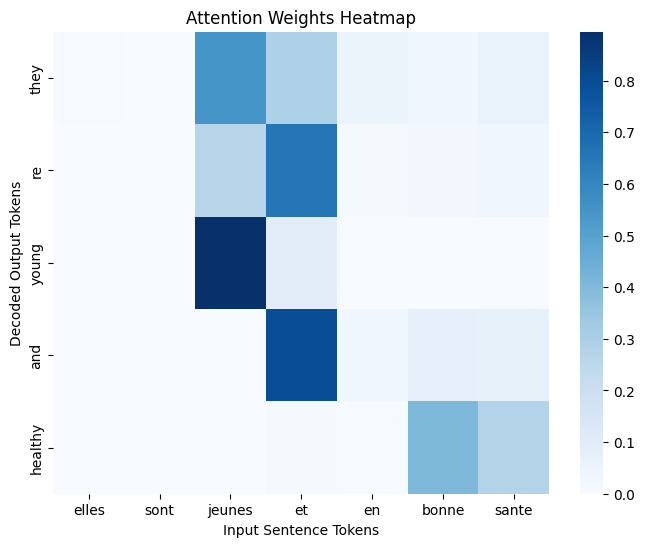

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn.functional as F

# Plot Attention Weights Heatmap
def plot_attention_weights(input_sentence, decoded_words, attention_weights, input_tokens, output_tokens):
    fig, ax = plt.subplots(figsize=(8, 6))
    attention_weights = attention_weights.squeeze(0).detach().cpu().numpy()

    sns.heatmap(
        attention_weights[:len(decoded_words), :len(input_sentence.split())],
        xticklabels=input_tokens,
        yticklabels=decoded_words,
        cmap='Blues',
        ax=ax
    )

    ax.set_title("Attention Weights Heatmap")
    ax.set_xlabel("Input Sentence Tokens")
    ax.set_ylabel("Decoded Output Tokens")
    plt.show()

# Generate Translations and Plot Attention
def visualize_attention_random_sample(encoder_model, decoder_model, source_language, target_language, sentence_pairs):
    # Randomly select a sentence pair
    random_pair = random.choice(sentence_pairs)
    source_sentence = random_pair[0]
    target_sentence = random_pair[1]

    # Generate translation and attention weights
    decoded_words, decoder_attention = generateTranslation(
        encoder_model, decoder_model, source_sentence, source_language, target_language
    )

    # Prepare tokens for visualization
    input_tokens = source_sentence.split()
    output_tokens = decoded_words[:-1]  # Exclude <END> token

    # Print sentences
    print(f"Source Sentence: {source_sentence}")
    print(f"Target Sentence: {target_sentence}")
    print(f"Translated Sentence: {' '.join(decoded_words)}")

    # Plot Attention Weights
    plot_attention_weights(source_sentence, output_tokens, decoder_attention, input_tokens, output_tokens)

# Visualize attention for a random sentence
visualize_attention_random_sample(
    encoder_model,
    decoder_model,
    source_language,
    target_language,
    sentence_pairs
)

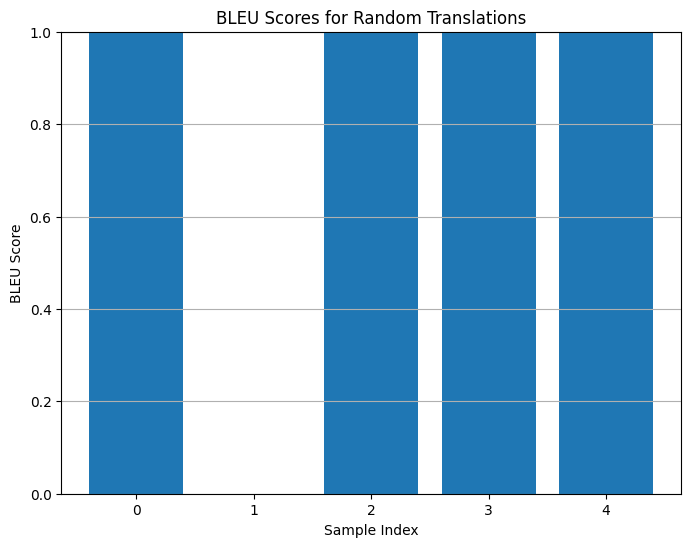

Sample 1:
Original: je ne suis plus inspiree
Translated: i m not inspired anymore
BLEU Score: 1.00
Sample 2:
Original: je suis en train de dormir
Translated: i m sleeping
BLEU Score: 0.00
Sample 3:
Original: nous sommes enneiges
Translated: we re snowed in
BLEU Score: 1.00
Sample 4:
Original: vous etes completement ignorantes
Translated: you re totally ignorant
BLEU Score: 1.00
Sample 5:
Original: ils sont tous la
Translated: they re all here
BLEU Score: 1.00


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def plot_bleu_scores(encoder_model, decoder_model, sentence_pairs, num_samples=10):
    bleu_scores = []
    original_sentences = []
    translated_sentences = []

    for _ in range(num_samples):
        random_pair = random.choice(sentence_pairs)
        source_sentence = random_pair[0]
        target_sentence = random_pair[1]
        decoded_words, _ = generateTranslation(encoder_model, decoder_model, source_sentence, source_language, target_language)

        bleu_score = sentence_bleu([target_sentence.split()], decoded_words[:-1])  # Exclude <END>
        bleu_scores.append(bleu_score)
        original_sentences.append(source_sentence)
        translated_sentences.append(' '.join(decoded_words[:-1]))

    # Plot BLEU scores
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(bleu_scores)), bleu_scores)
    plt.title("BLEU Scores for Random Translations")
    plt.xlabel("Sample Index")
    plt.ylabel("BLEU Score")
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.show()

    # Print sentences with BLEU scores
    for i, (original, translated, score) in enumerate(zip(original_sentences, translated_sentences, bleu_scores)):
        print(f"Sample {i+1}:")
        print(f"Original: {original}")
        print(f"Translated: {translated}")
        print(f"BLEU Score: {score:.2f}")
        print("="*50)

# Example usage
plot_bleu_scores(encoder_model, decoder_model, sentence_pairs, num_samples=5)